In [82]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
# https://pytorch.org/docs/stable/nn.html#torch-nn-functional
import torch.nn.functional as F

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_idx = torch.cuda.current_device()
device_name = torch.cuda.get_device_name(device_idx)
device_cap = torch.cuda.get_device_capability(device_idx)
print('PyTorch: Using {} Device {}:{} with Compute Capability {}.{}'
      .format(str(device).upper(), device_name, device_idx, device_cap[0], device_cap[1]))

PyTorch: Using CUDA Device GeForce GTX 1050 Ti:0 with Compute Capability 6.1


In [13]:
SOS_token = 0 # Start of Sentence token
EOS_token = 1 # End of Sentence token

class Lang:
    
    def __init__(self, name):
        self.name = name
        self.word_to_idx = {}
        self.word_to_count = {}
        self.idx_to_word = {0: 'SOS', 1: 'EOS'}
        self.n_words = 2
        
    def add_word(self, word):
        if word not in self.word_to_idx:
            self.word_to_idx[word] = self.n_words
            self.word_to_count[word] = 1
            self.idx_to_word[self.n_words] = word
            self.n_words += 1
        else:
            self.word_to_count[word] += 1
        
    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

In [14]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) 
        if unicodedata.category(c) != 'Mn'
    )

# Convert to Lowercase, Trim and Remove non-letter chars
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [15]:
def read_langs(lang1, lang2, reverse=False):
    
    print('Reading lines...')
    
    # Read the file and split into lines
    lines = open('data/{}-{}.txt'.format(lang1, lang2), encoding='utf-8') \
            .read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else: 
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

In [16]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH and \
            p[1].startswith(eng_prefixes)

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

In [12]:
def prepare_data(lang1, lang2, reverse=False):
    
    input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse)
    print('Read {} sentence pairs'.format(len(pairs)))
    
    pairs = filter_pairs(pairs)
    print('Trimmed to {} sentence pairs'.format(len(pairs)))
    
    print('Counting words...')
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    
    print('Counted words:')
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['je ne vais pas manger ce poisson .', 'i m not eating this fish .']


In [22]:
"""
Encoder RNN Model
"""
class EncoderRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        # https://pytorch.org/docs/stable/nn.html#torch.nn.Module
        super(EncoderRNN, self).__init__() # nn.Module is Base class for all NNs
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input_seq, hidden):
        # https://stackoverflow.com/questions/42479902/how-view-method-works-for-tensor-in-torch
        embedded = self.embedding(input_seq).view(1, 1, -1) # view means to reshape a tensor
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def init_hidden(self):
        # https://pytorch.org/docs/stable/torch.html#torch.zeros
        return torch.zeros(1, 1, self.hidden_size, device=device) # initial value of hidden

In [24]:
"""
Decoder RNN Model
"""
class DecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        # Layer(input_size, hidden_size)
        # here output_size -> encoder output and 
        # hidden_size -> GRU output and hidden size
        self.embedding = nn.Embedding(output_size, hidden_size) 
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_seq, hidden):
        output = self.embedding(input_seq).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [53]:
"""
Attention Decoder RNN Model
"""
class AttnDecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input_seq, hidden, encoder_outputs):
        embedded = self.embedding(input_seq).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        # https://pytorch.org/docs/stable/torch.html#torch.cat (concatenation)
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        # https://pytorch.org/docs/stable/torch.html#torch.bmm
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), 
                                 encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [41]:
def indices_from_sentence(lang, sentence):
    return [lang.word_to_idx[word] for word in sentence.split(' ')]

def tensor_from_sentence(lang, sentence):
    indices = indices_from_sentence(lang, sentence)
    indices.append(EOS_token)
    return torch.tensor(indices, dtype=torch.long, device=device).view(-1, 1)

def tensors_from_pair(pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [42]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.init_hidden()
    
    # https://stackoverflow.com/questions/48001598/why-is-zero-grad-needed-for-optimization
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, 
                        encoder.hidden_size, device=device)
    
    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di] # Teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # https://pytorch.org/docs/stable/torch.html#torch.topk
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() # detach from history as input
            
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
                
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

In [63]:
import time
import math

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '{}m {:.2f}s'.format(m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return 'ETA: {} (~ {})'.format(as_minutes(rs), as_minutes(s))

In [64]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this location puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [65]:
def train_iterations(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    
    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0 # Reset every plot_every 
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    training_pairs = [tensors_from_pair(random.choice(pairs)) for i in range(n_iters)]
    
    # https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss
    criterion = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        training_pair = training_pairs[iteration - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder, decoder, 
                     encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        if iteration % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('Epoch {}/{}: {:.2f}% | Loss: {:.2f} | {}'
                 .format(iteration, n_iters, (iteration / n_iters) * 100,
                  print_loss_avg, time_since(start, iteration / n_iters)))
        
        if iteration % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        
    show_plot(plot_losses)

In [77]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        encoder_hidden = encoder.init_hidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], 
                                                    encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
            
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.idx_to_word[topi.item()])
            decoder_input = topi.squeeze().detach()
            
        return decoded_words, decoder_attentions[: di + 1]

In [78]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('Input: {}'.format(pair[0]))
        print('Target: {}'.format(pair[1]))
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Predicted: {}\n'.format(output_sentence))

In [68]:
hidden_size = 256

encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

train_iterations(encoder1, attn_decoder1, 75000, print_every=1000)

Epoch 1000/75000: 1.33% | Loss: 3.46 | ETA: 71m 39.82s (~ 0m 58.11s)
Epoch 2000/75000: 2.67% | Loss: 2.92 | ETA: 65m 26.87s (~ 1m 47.59s)
Epoch 3000/75000: 4.00% | Loss: 2.73 | ETA: 63m 7.13s (~ 2m 37.80s)
Epoch 4000/75000: 5.33% | Loss: 2.65 | ETA: 61m 47.46s (~ 3m 28.87s)
Epoch 5000/75000: 6.67% | Loss: 2.52 | ETA: 60m 52.23s (~ 4m 20.87s)
Epoch 6000/75000: 8.00% | Loss: 2.52 | ETA: 59m 53.82s (~ 5m 12.51s)
Epoch 7000/75000: 9.33% | Loss: 2.38 | ETA: 58m 59.12s (~ 6m 4.32s)
Epoch 8000/75000: 10.67% | Loss: 2.23 | ETA: 58m 3.56s (~ 6m 55.95s)
Epoch 9000/75000: 12.00% | Loss: 2.20 | ETA: 57m 7.33s (~ 7m 47.36s)
Epoch 10000/75000: 13.33% | Loss: 2.20 | ETA: 56m 21.82s (~ 8m 40.28s)
Epoch 11000/75000: 14.67% | Loss: 2.08 | ETA: 55m 27.14s (~ 9m 31.85s)
Epoch 12000/75000: 16.00% | Loss: 2.01 | ETA: 54m 26.81s (~ 10m 22.25s)
Epoch 13000/75000: 17.33% | Loss: 2.01 | ETA: 53m 34.02s (~ 11m 13.91s)
Epoch 14000/75000: 18.67% | Loss: 1.93 | ETA: 52m 40.79s (~ 12m 5.43s)
Epoch 15000/75000: 20.00

In [79]:
evaluate_randomly(encoder1, attn_decoder1)

Input: ils sont incroyables .
Target: they re amazing .
Predicted: they re amazing . <EOS>

Input: je suis juste un type normal .
Target: i m just a normal guy .
Predicted: i m just an average guy . <EOS>

Input: elle porte un chapeau .
Target: she is wearing a hat .
Predicted: she is wearing a hat . <EOS>

Input: je suis un peu ivre .
Target: i am a bit drunk .
Predicted: i m a bit drunk . <EOS>

Input: nous sommes dans les temps .
Target: we re on schedule .
Predicted: we re on . <EOS>

Input: nous ne rajeunissons pas .
Target: we re not getting any younger .
Predicted: we re not getting any . <EOS>

Input: vous n etes pas la seule femme ici .
Target: you re not the only woman here .
Predicted: you re not the only woman here . <EOS>

Input: il est en retard .
Target: he is late .
Predicted: he s late . <EOS>

Input: je suis surprise que vous ignoriez cela .
Target: i m surprised you didn t know that .
Predicted: i m surprised you didn t know that that .

Input: c est une excellente e

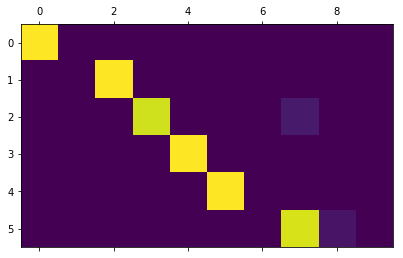

In [85]:
output_words, attentions = evaluate(encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she is six years younger than me . <EOS>


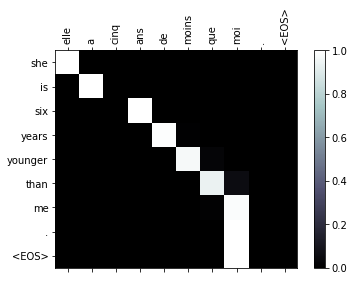

input = elle est trop petit .
output = she s too fat . <EOS>


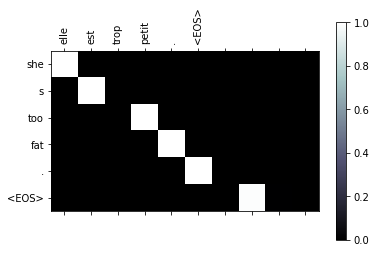

input = je ne crains pas de mourir .
output = i m not scared of die . <EOS>


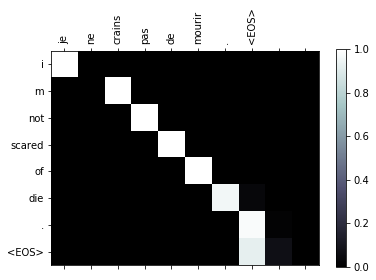

input = c est un jeune directeur plein de talent .
output = he s an talented talented . <EOS>


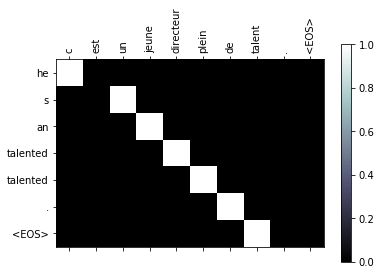

In [83]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")
evaluateAndShowAttention("elle est trop petit .")
evaluateAndShowAttention("je ne crains pas de mourir .")
evaluateAndShowAttention("c est un jeune directeur plein de talent .")